# SD DSL: Under The Hood
**Creating A Domain Specific Language For System Dynamics Simulations**

Part of the BPTK Framework is the *System Dynamics Domain Specific Language (SD DSL)*. Using the SD DSL, you can easily build System Dynamics Mmodels directly in Python using an intuitive Syntax. 

This notebook takes a look under the hood of the SD DSL and explains how it creates the underlying equations that are needed to run a simulation.

This should give you a better understanding of System Dynamics, of the SD DSL and of Python metaprogramming techniques.

The following diagram contains the three key System Dynamics language elements:

* Stocks
* Flows
* Converters

![Simple System Dynamics Model](sfd_simple_model.svg)

At any given time $t$, a stock is equal to the value of the stock at time $t-1$ plus the sum of all inflows, minus the sum of all outflow at time $t-1$ are simply the sum of the flows that flow into and out of them, over time.

Flows and converters are simply functions of their inputs.

The general mathematical equations for the stocks above are:

\begin{equation*}
stock(t)=stock(t-1)+\sum_{inflows}inflow(t-1)-\sum_{outflows}outflow(t-1)
\end{equation*}

\begin{equation*}
flow(t) = function(input_1,...,input_n)
\end{equation*}

\begin{equation*}
converter(t) = function(input_1,...,input_n)
\end{equation*}

The concrete equations for the model in the diagram above are:

\begin{equation*}
stock(t)=stock(t-1)+\sum_{inflows}inflow(t-1)
\end{equation*}

\begin{equation*}
flow(t) = stock(t)*rate(t)
\end{equation*}

\begin{equation*}
rate(t) = 0.1
\end{equation*}

\begin{equation*}
stock(0) = 1
\end{equation*}

The SD DSL allows us to write SD models in Python using a simple syntax:

```python
stock = model.stock("stock")
flow = model.flow("flow")
rate = model.converter("rate")
stock.initial_value = 1
rate.equation=0.1
flow.equation=stock*rate
stock.equation=flow
```

But under the hood, the SD DSL needs to build the equations listed above to ensure that we can simulate the model.

Let's take a look at how this is done, step by step.

## Step 1: Write Python Code For The Equations Above

The SD DSL uses lambda functions lambda functions to implement the equation if the System Dynamics model.

In [ ]:
import pandas as pd
import matplotlib

In [3]:
stock = lambda t: stock(t-1) + flow(t-1) if t>0 else 1

In [4]:
flow = lambda t: stock(t) * rate(t)

In [5]:
rate = lambda t: 0.1

In [6]:
stock(10)

2.5937424601

## Step 2: Plot The Resulting Equation

Plot the stock equation for 20 timesteps, e.g. using a pandas dataframe.

In [7]:
df = pd.DataFrame((stock(t)) for t in range(0,20) )

<Axes: >

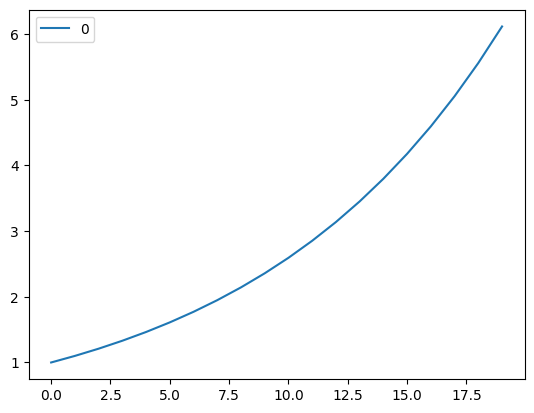

In [8]:
df.plot(kind="line")

## Step 3: Keep Equations in A Dictionary

Assume we want to keep equations in a "model" and add new ones dynamically:  create a dictioanry of equations that are accessed by equation names as strings, e.g. `equation["stock"](5)`

In [9]:
equations={}

In [10]:
equations["stock"] = lambda t: equations["stock"](t-1) + equations["flow"](t-1) if t>0 else 1

In [11]:
equations["flow"] = lambda t: equations["stock"](t) * equations["rate"](t)

In [12]:
equations["rate"] = lambda t: 0.1

In [13]:
equations["stock"](10)

2.5937424601

## Step 4: Use Memoization To Improve Performance

In order to calculate the value of a stock at a given time $t$, you need to know all preceding values. The way the model is encoded at the moment, this means that we first calculate the value at time $t = 1$, then to calculate the value at time $t = 2$ we need to calcualte the values at time $t=1$ and then at time $t =2$ and so on ... this means that even models with only few timesteps can take a very long time to evaluate.

The way around this of course is to remember the value of each equation at each time step, so that you don't have to recurse through all timesteps at every timestep.

We do this using a technique called _memoization_.

In [14]:
%timeit equations["stock"](10)

151 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [14]:
%timeit equations["stock"](20)

519 ms ± 3.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
equations={}

In [16]:
memo={}

The memoization function stores the value of each equation at each timestep. When asking for the value of an equation at a given time, it first checks if the value has already been calculated. If yes, it returns that value. If no, it calculates the value, stores it and then returns it.

In [18]:
def memoize(equation, time):
        
        try:
            mymemo = memo[equation]
        except:
            # In case the equation does not exist in memo
            memo[equation] = {}
            mymemo = memo[equation]
        if time in mymemo.keys():
            return mymemo[time]
        else:
            result = equations[equation](time)
            mymemo[time] = result

        return result

In [19]:
equations["stock"] = lambda t: memoize("stock",t-1) + memoize("flow",t-1) if t>0 else 1

In [20]:
equations["flow"] = lambda t: memoize("stock",t) * memoize("rate",t)

In [21]:
equations["rate"] = lambda t: 0.1

In [22]:
equations["stock"](5)

1.61051

In [23]:
%timeit equations["stock"](20)

187 ns ± 0.171 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [24]:
%timeit equations["stock"](30)

187 ns ± 1.23 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [25]:
equations["stock"](50)

117.39085287969533

In [26]:
df = pd.DataFrame((equations["stock"](t)) for t in range(0,50) )

<Axes: >

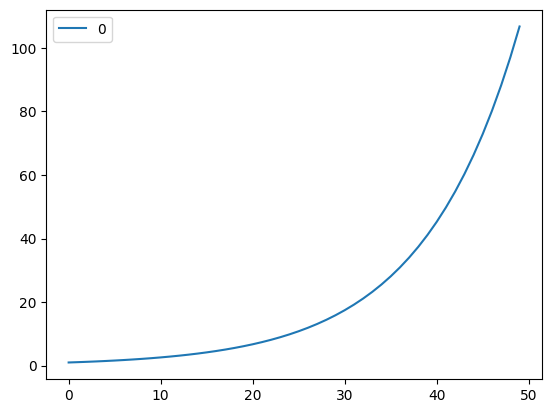

In [27]:
df.plot(kind="line")

## Step 5: Compile Equations From Strings

Now that we know what equations we want, we need a find a way of generating them directly. We do this by first generating the code in string form and then compiling that string into code using the `eval`function.

In [28]:
equations["stock"]=eval("lambda t: memoize('stock',t-1) + memoize('flow',t-1) if t>0 else 1")

In [28]:
equations["stock"](5)

1.61051

In [29]:
equations["stock"]

<function __main__.<lambda>(t)>

## Step 6: Encapsulate The Basic Functionality In Classes

Now that we have all the building blocks for our SD DSL, we would like to encapsulate them in classes that allow us to build a model at runtime.

We want to be able to build a model using objects at runtime, the underlying equations should be generated for us.

* Create classes for the model (that will hold the model elements and equations) and for the elements themselves.
* New elements are created using the model as a factory (e.g. `another_stock = model.stock("name of another stock")`)
* Elements know which model they belong to
* The equations for each element are defined using an equation method on the elements (e.g. `stock.equation=flow`)
* The memoization function should be part of the model class
* Each element should have a term function `element.term` that generate a string representation of itself (e.g `model.memoize("stock",t)`)
* Remember that stocks have an initial value

In [40]:
class Model:
    def __init__(self):
        self._stocks = {}
        self._flows = {}
        self._converters = {}
        self._memo={}
        
    def stock(self, name):
        if name not in self._stocks:
            self._stocks[name] = Stock(model, name)
        return self._stocks[name]
    
    def flow(self, name):
        if name not in self._flows:
            self._flows[name] = Flow(model, name)
        return self._flows[name]
    
    def converter(self, name):
        if name not in self._converters:
            self._converters[name] = Converter(model, name)
        return self._converters[name]
    
    def memoize(self,equation, arg):
        
        try:
            mymemo = self._memo[equation]
        except:
            # In case the equation does not exist in memo
            self._memo[equation] = {}
            mymemo = self._memo[equation]
        if arg in mymemo.keys():
            return mymemo[arg]
        else:
            result = self._equations[equation](arg)
            mymemo[arg] = result

        return result

In [41]:
class Element:
    def __init__(self, model, name):
        self._model = model
        self._name = name
        self._equation = None
    
    @property
    def equation(self):
        return self._equation
    
    @equation.setter
    def equation(self, equation):
        self._equation = equation
        
    def term(self,time="t"):
        return "model.memoize('{}',{})".format(self._name, time)

In [42]:
class Stock(Element):
    
    def __init__(self,model, name):
        super(Stock, self).__init__(model, name)
        self._initial_value = 0
        
    @property
    def initial_value(self):
        return self._initial_value
    
    @initial_value.setter
    def initial_value(self, value):
        self._initial_value=value

    
class Flow(Element): 
    pass
    
class Converter(Element):
    pass
    

In [43]:
model = Model()

In [44]:
stock = model.stock("stock")

In [45]:
stock.term()

"model.memoize('stock',t)"

In [46]:
stock.initial_value=1

In [47]:
rate = model.converter("rate")

In [48]:
rate.term()

"model.memoize('rate',t)"

In [49]:
flow = model.flow("flow")

In [50]:
flow.term()

"model.memoize('flow',t)"

In [51]:
stock.equation = flow

In [52]:
stock._equation

In [53]:
rate.equation=10

## Step 7: Auto-Generate The Equations

Extend the framework to auto-generate the underlying lambda-equations and add them to the model. For the first version assume we just have a stock and a constant flow.

Override the call operator to evalue the element at a particular timestep (e.g. `stock(10)`)

Create a plot function that evaluates an element in the range 0 to 100.

In [44]:
class Model:
    def __init__(self):
        self._stocks = {}
        self._flows = {}
        self._converters = {}
        self._memo={}
        self._equations={}
        
    def stock(self, name):
        if name not in self._stocks:
            self._stocks[name] = Stock(model, name)
        return self._stocks[name]
    
    def flow(self, name):
        if name not in self._flows:
            self._flows[name] = Flow(model, name)
        return self._flows[name]
    
    def converter(self, name):
        if name not in self._converters:
            self._converters[name] = Converter(model, name)
        return self._converters[name]
    
    def memoize(self,equation, arg):
        
        try:
            mymemo = self._memo[equation]
        except:
            # In case the equation does not exist in memo
            self._memo[equation] = {}
            mymemo = self._memo[equation]
        if arg in mymemo.keys():
            return mymemo[arg]
        else:
            result = self._equations[equation](arg)
            mymemo[arg] = result

        return result

In [45]:
class Element:
    def __init__(self, model, name):
        self._model = model
        self._name = name
        self._equation = None
        self._function_string=""
    
    @property
    def equation(self):
        return self._equation
    
    @equation.setter
    def equation(self, equation):
        self._equation = equation
        self._function_string = "lambda model, t: {}".format(equation)
        self.generate_function()
        
    def generate_function(self):
        """
        Generate the function using the function_string value and eval()
        :return: None
        """
        fn = eval(self._function_string)
        self._model._equations[self._name] = lambda t: fn(self._model, t)
        self._model._memo[self._name] = {}
        
    def term(self,time="t"):
        return "model.memoize('{}',{})".format(self._name, time)
    
    def plot(self):
        df = pd.DataFrame((self(t)) for t in range(0,100) )
        df.plot(kind="line")
        
    def __call__(self, *args, **kwargs):
        return self._model._equations[self._name](args[0])
    
    def __str__(self, other):
        return self.term()

In [46]:
class Stock(Element):
    type="Stock"
    
    def __init__(self,model, name):
        super(Stock, self).__init__(model, name)
        self._initial_value = 0
        
    @property
    def initial_value(self):
        return self._initial_value
    
    @initial_value.setter
    def initial_value(self, value):
        self._initial_value=value

    @property
    def equation(self):
        return self._equation

    @equation.setter
    def equation(self, equation):
        self._equation = equation

        self._function_string = "lambda model, t : ( ("
        self._function_string += str(self._initial_value)
        self._function_string += ") if (t <= 0) else (model.memoize('{}',t-1)) ".format(self._name)

        if self._equation is not None:
            self._function_string += "+ ("
            self._function_string += self._equation.term("t-1")
            self._function_string += ") )"
        else:
            self._function_string += ")"
        
        self.generate_function()

    
class Flow(Element): 
    type="Flow"
    
class Converter(Element):
    type="Converter"
    

In [47]:
model = Model()

In [48]:
stock = model.stock("stock")

In [49]:
stock.term()

"model.memoize('stock',t)"

In [50]:
stock.initial_value=1

In [51]:
flow = model.flow("flow")

In [52]:
flow.term()

"model.memoize('flow',t)"

In [53]:
flow.equation=1

In [54]:
stock.equation = flow

In [55]:
stock._equation

In [56]:
model._equations

{'flow': <function __main__.Element.generate_function.<locals>.<lambda>(t)>,
 'stock': <function __main__.Element.generate_function.<locals>.<lambda>(t)>}

In [57]:
flow(10)

1

In [58]:
stock(10)

11

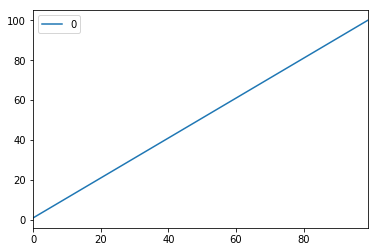

In [59]:
stock.plot()

## Step 8: Extend the Equation Syntax Using Operators

In order to re-create our initial model, we need to formulate an equation such as `flow.equation = stock*rate`.

Override the `__mul__` methods of the Element and create a multiplication operator to deal with this.

In [60]:
class Model:
    def __init__(self):
        self._stocks = {}
        self._flows = {}
        self._converters = {}
        self._memo={}
        self._equations={}
        
    def stock(self, name):
        if name not in self._stocks:
            self._stocks[name] = Stock(model, name)
        return self._stocks[name]
    
    def flow(self, name):
        if name not in self._flows:
            self._flows[name] = Flow(model, name)
        return self._flows[name]
    
    def converter(self, name):
        if name not in self._converters:
            self._converters[name] = Converter(model, name)
        return self._converters[name]
    
    def memoize(self,equation, arg):
        
        try:
            mymemo = self._memo[equation]
        except:
            # In case the equation does not exist in memo
            self._memo[equation] = {}
            mymemo = self._memo[equation]
        if arg in mymemo.keys():
            return mymemo[arg]
        else:
            result = self._equations[equation](arg)
            mymemo[arg] = result

        return result

In [61]:
class Element:
    def __init__(self, model, name):
        self._model = model
        self._name = name
        self._equation = None
        self._function_string=""
    
    @property
    def equation(self):
        return self._equation
    
    @equation.setter
    def equation(self, equation):
        self._equation = equation
        self._function_string = "lambda model, t: {}".format(equation)
        self.generate_function()
        
    def generate_function(self):
        """
        Generate the function using the function_string value and eval()
        :return: None
        """
        fn = eval(self._function_string)
        self._model._equations[self._name] = lambda t: fn(self._model, t)
        self._model._memo[self._name] = {}
        
    def term(self,time="t"):
        return "model.memoize('{}',{})".format(self._name, time)
    
    def plot(self):
        df = pd.DataFrame((self(t)) for t in range(0,100) )
        df.plot(kind="line")
        
    def __call__(self, *args, **kwargs):
        return self._model._equations[self._name](args[0])
    
    def __mul__(self, other):
        return MultiplicationOperator(self, other)
    
    def __str__(self):
        return self.term()

In [62]:
class MultiplicationOperator():

    def __init__(self, element_1, element_2):
        self._element_1 = element_1
        self._element_2 = element_2
        
    def term(self, time="t"):
        return "(" + self._element_1.term(time) + ") * (" + self._element_2.term(time) + ")"
    
    def __str__(self):
        return self.term()

In [63]:
class Stock(Element):
    type="Stock"
    
    def __init__(self,model, name):
        super(Stock, self).__init__(model, name)
        self._initial_value = 0
        
    @property
    def initial_value(self):
        return self._initial_value
    
    @initial_value.setter
    def initial_value(self, value):
        self._initial_value=value

    @property
    def equation(self):
        return self._equation

    @equation.setter
    def equation(self, equation):
        self._equation = equation

        self._function_string = "lambda model, t : ( ("
        self._function_string += str(self._initial_value)
        self._function_string += ") if (t <= 0) else (model.memoize('{}',t-1)) ".format(self._name)

        if self._equation is not None:
            self._function_string += "+ ("
            self._function_string += self._equation.term("t-1")
            self._function_string += ") )"
        else:
            self._function_string += ")"
        
        self.generate_function()

    
class Flow(Element): 
    type="Flow"
    
class Converter(Element):
    type="Converter"
    

In [64]:
model = Model()

In [65]:
stock = model.stock("stock")

In [66]:
flow = model.flow("flow")

In [67]:
rate = model.converter("rate")

In [68]:
rate.equation=0.1

In [69]:
stock.initial_value=1

In [70]:
stock.equation = flow

In [71]:
flow.equation = stock*rate

In [72]:
stock(3)

1.3310000000000002

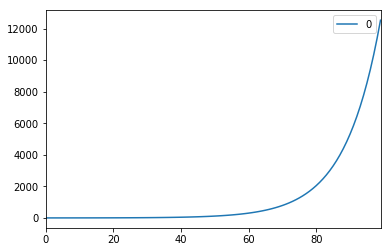

In [73]:
stock.plot()